In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import sklearn as sk
import os

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
pd.options.mode.use_inf_as_na = True
DATA_FOLDER = '/home/roger/code/kaggle/predict-future-sales/data'

transactions       = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
items              = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories    = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
item_categories_en = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories_en.csv'))
shops              = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
shops_en           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops_en.csv'))
test               = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
sample             = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))

# Adding English translations to item_categories and shops
item_categories = item_categories.merge(
    item_categories_en[["item_category_id", "item_category_name"]]
        .rename(columns={"item_category_name":"item_category_name_en"}),
    on="item_category_id")
item_categories.head()

shops = shops.merge(
    shops_en[["shop_id", "shop_name"]]
        .rename(columns={"shop_name":"shop_name_en"}),
    on="shop_id")

index_vars = ["date_block_num", "shop_id", "item_id"]

In [6]:
print(transactions.head(2).T)
print(items.head(1).T)
print(item_categories.head(2).T)
print(shops.head(2).T)

                         0           1
date            02.01.2013  03.01.2013
date_block_num           0           0
shop_id                 59          25
item_id              22154        2552
item_price           999.0       899.0
item_cnt_day           1.0         1.0
                                                          0
item_name         ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D
item_id                                                   0
item_category_id                                         40
                                                0                  1
item_category_name        PC - Гарнитуры/Наушники   Аксессуары - PS2
item_category_id                                0                  1
item_category_name_en  PC - Headsets / Headphones  Accessories - PS2
                                               0  \
shop_name          !Якутск Орджоникидзе, 56 фран   
shop_id                                        0   
shop_name_en  ! Yakutsk Ordzhonikidze, 56 francs   

  

In [7]:
train = (transactions
    .merge(items, on="item_id")
    .merge(item_categories, on="item_category_id")
    .merge(shops, on="shop_id"))

# Converting date to dt format
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

In [8]:
# Month and Season categories.
seasons={
    "01":"2",
    "02":"2",
    "03":"3",
    "04":"3",
    "05":"3",
    "06":"4",
    "07":"4",
    "08":"4",
    "09":"1",
    "10":"1",
    "11":"1",
    "12":"2",
}

train["month"] = pd.DatetimeIndex(train["date"]).month
train["month"] = train["month"].apply(lambda x: f"{x:02}")
train["season"] = train["month"].map(seasons)
train["quarter"] = (train["month"].apply(int)+2)//3
train["quarter"] = train["quarter"].apply(str)

[]

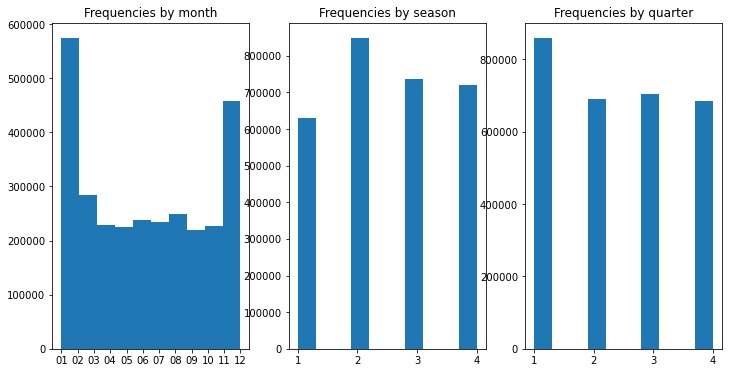

In [9]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12,6)
ax[0].hist(train["month"].sort_values())
ax[0].set_title(label="Frequencies by month")
ax[1].hist(train["season"].sort_values())
ax[1].set_title(label="Frequencies by season")
ax[2].hist(train["quarter"].sort_values())
ax[2].set_title(label="Frequencies by quarter")
plt.plot()

[]

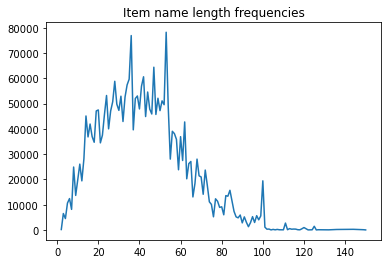

In [19]:
# item_name
train["item_name_length"] = train["item_name"].apply(lambda x:len(x.strip()))
train["item_name_length"].value_counts().sort_index().plot()
plt.title("Item name length frequencies")
plt.plot()

In [40]:
#Converting item_name, item_category_name, and shop_name to bow

def word_counts(df, name_col, bow_name_prefix, top_n_words=None):
    vectorisor = CountVectorizer(strip_accents="unicode", lowercase=True)
    x = vectorisor.fit_transform(df[name_col])
    counts = x.sum(axis=0).tolist()[0]
    words = vectorisor.get_feature_names()

#     Creates a df from bow index, words and count
    bow_reference = (pd.DataFrame(zip(words, counts), columns=["words", "counts"])
        .reset_index()
        .rename(columns={"index":"bow_key"})
        .sort_values("counts",ascending=False))
    if top_n_words is None:
        min_count = 1
    else:
        min_count = bow_reference.iloc[top_n_words]["counts"]
        
    bow_reference["top_n"] = bow_reference["counts"] > min_count

    #     appends top_n word columns to df
    keys = bow_reference[bow_reference["top_n"]]["bow_key"]
        
    out = df.merge(
        pd.DataFrame(
            x[:, keys].toarray(),
            columns=[f"{bow_name_prefix}{key}" for key in keys]),
        left_index=True,
        right_index=True)
    
    return out, bow_reference

In [14]:
items, item_bow_ref = word_counts(items, "item_name", "item_bow_", 100)
items_cat_bow, items_cat_bow_ref = word_counts(item_categories, "item_category_name", "cat_bow_")
shops_bow, shops_bow_ref = word_counts(shops, "shop_name", "shop_bow_")

[]

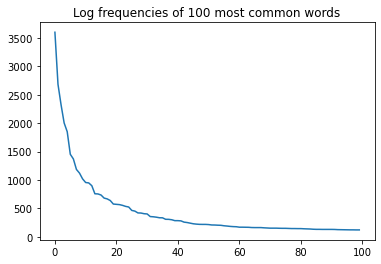

In [15]:
top_n = 100
plt.plot(
    range(top_n), 
    item_bow_ref["counts"].sort_values(ascending=False).apply(lambda x: x).head(top_n))
plt.title(f"Log frequencies of {top_n} most common words")
# ax[1].plot(range(top_n), test["counts"].sort_values(ascending=False).head(top_n))
plt.plot()

In [16]:
# Months_on_sale
# TODO: Cannot tell how many months item was sold before dataset started.
sales_by_month = (train[index_vars + ["item_cnt_day"]]
                   .groupby(index_vars)
                   .agg("sum")
                   .rename(columns={"item_cnt_day":"item_cnt_month"})
                   .reset_index())
first_month = (sales_by_month[sales_by_month["item_cnt_month"] > 0]
               .groupby(["shop_id", "item_id"])
               .agg({"date_block_num":"min"})
               .rename(columns={"date_block_num":"first_sold_month"})
               .reset_index())
first_month = first_month.astype({"first_sold_month":object})
sales_by_month = sales_by_month.merge(first_month, on=["shop_id", "item_id"], how="left")
sales_by_month["months_since_first_sale"] = sales_by_month["date_block_num"]-sales_by_month["first_sold_month"]

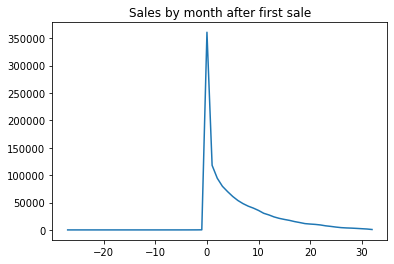

In [17]:
# TODO: Is month 1 sales an error? https://hitboxteam.com/dustforce-sales-figures
# Negative month of first sale are returns.
(sales_by_month[sales_by_month["first_sold_month"]!=0]["months_since_first_sale"]
.value_counts()
.sort_index()
.plot(title="Sales by month after first sale"))
plt.show()

In [18]:
# item_cnt_month-i counts lagged by i months.
for i in range(1,13):
    sales_by_month[f"month-{i}"] = sales_by_month["date_block_num"]-i
    
for i in range(1,13):
    left_vars = [f"month-{i}", "shop_id", "item_id"]

    sales_by_month = sales_by_month.merge(
                sales_by_month[index_vars+["item_cnt_month"]].rename(columns={"item_cnt_month":f"item_cnt_month-{i}"}),
                left_on=left_vars,
                right_on=index_vars,
                how="left",
                suffixes=("","_y"))
    sales_by_month = sales_by_month.drop(columns="date_block_num_y")